Importing necessary libraries

In [26]:
import io
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from collections import defaultdict, Counter

Loading dataset file from computer

In [13]:
uploaded = files.upload()

Saving reviews.csv to reviews (6).csv


In [14]:
path = io.BytesIO(uploaded['reviews.csv'])
data = pd.read_csv(path)

Dropping Id column

In [15]:
data = data.drop(['Id'], axis=1)

Assigning columns to X and Y

In [16]:
X = data['Review']
Y = data['Label']

Counting ratings per category

In [17]:
ratings = pd.DataFrame(data.groupby('Label').size()).reset_index()
ratings.columns = ['Stars', 'count']
ratings

,Stars,count
0,1,2469
1,2,2251
2,3,5071
3,4,18054
4,5,79173


Visualizing the labels in a form of bar chart 

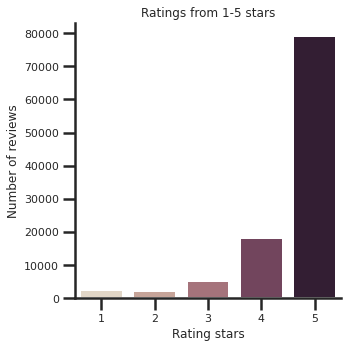

In [18]:
from matplotlib.pyplot import figure
sns.set(context = 'poster', style = 'ticks', font_scale = 0.5)
sns.catplot(x = "Stars", y = "count", kind  = 'bar', palette = "ch:.25", data = ratings)
plt.title('Ratings from 1-5 stars')
plt.xlabel('Rating stars')
plt.ylabel('Number of reviews')
sns.despine()
plt.tight_layout();

Cleaning texts 

In [19]:
def clean_text(str):
    clean = re.sub('[^a-z\s]+', ' ', str, flags = re.IGNORECASE) 
    clean = re.sub('(\s+)', ' ', clean) 
    clean = clean.lower() 
        
    return clean 

Building Naive Bayes Classifier

In [20]:
class NaiveBayes:
    
    def __init__(self, distinct_classes):
        self.classes = distinct_classes
        
    def bag_of_words(self, samples, indx):
        if isinstance(samples, np.ndarray): 
          samples = samples[0]
     
        for token in samples.split():
            self.dictionary[indx][token] += 1
            
    def train(self, data, labels):
        self.samples = data
        self.labels = labels
        self.dictionary = np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])
        
        if not isinstance(self.samples, np.ndarray): 
          self.samples = np.array(self.samples)

        if not isinstance(self.labels, np.ndarray): 
          self.labels = np.array(self.labels)
            
        for indx, category in enumerate(self.classes):
            all_samples = self.samples[self.labels == category] 
            clean_samples = [clean_text(category_sample) for category_sample in all_samples]
            
            clean_samples = pd.DataFrame(data = clean_samples)
            np.apply_along_axis(self.bag_of_words, 1, clean_samples, indx)
            
        class_probability = np.empty(self.classes.shape[0])
        all_words = []
        category_counts = np.empty(self.classes.shape[0])
        for indx, category in enumerate(self.classes):
            class_probability[indx] = np.sum(self.labels == category) / float(self.labels.shape[0]) 
            
            count = list(self.dictionary[indx].values())
            category_counts[indx] = np.sum(np.array(list(self.dictionary[indx].values()))) + 1                               
            all_words += self.dictionary[indx].keys()
                                                        
        self.vocabulary = np.unique(np.array(all_words))
        self.vocab_size = self.vocabulary.shape[0]
                                                                      
        devisor = np.array([category_counts[indx] + self.vocab_size + 1 for indx, category in enumerate(self.classes)])                                                                          
        self.category_data = [(self.dictionary[indx], class_probability[indx], devisor[indx]) for indx, cat in enumerate(self.classes)]                               
        self.category_data =np.array(self.category_data)                                 
                                                                                  
    def sample_probability(self, test_sample):                                                                            
        likelihood = np.zeros(self.classes.shape[0]) 
        for indx, category in enumerate(self.classes):                 
            for tokenize in test_sample.split():                          
                tokenize_counts = self.category_data[indx][0].get(tokenize, 0) + 1                             
                token_probability = tokenize_counts / float(self.category_data[indx][2])                      
                likelihood[indx] += np.log(token_probability)
                          
        posterior = np.empty(self.classes.shape[0])
        for indx, category in enumerate(self.classes):
            posterior[indx]= likelihood[indx] + np.log(self.category_data[indx][1])                                  
      
        return posterior
    
    def test(self, test_data):
        predictions=[] 
        for sample in test_data:                                  
            clean_sample = clean_text(sample)                             
            posterior = self.sample_probability(clean_sample)            
            predictions.append(self.classes[np.argmax(posterior)])
                
        return np.array(predictions)

In [21]:
#Splitting 80% of data for training and 20% for test
train_percent = 80
train_size = int((train_percent*len(data))/100)
X_train_reviews = X.iloc[:train_size]
Y_train_labels = Y.iloc[:train_size]
X_test_reviews = X.iloc[train_size:]
Y_test_labels = Y.iloc[train_size:]
classes = np.unique(Y_train_labels)

In [22]:
Naive_Bayes_Model = NaiveBayes(classes)
print("----------Training In Progress----------")
print("-         Training Examples: ", X_train_reviews.shape[0])
Naive_Bayes_Model.train(X_train_reviews, Y_train_labels)
print("----------Training Completed!-----------")

----------Training In Progress----------
-         Training Examples:  85614
----------Training Completed!-----------


In [23]:
print("----------Training In Progress----------")
p_c = Naive_Bayes_Model.test(X_test_reviews)
Accuracy = np.sum(p_c == Y_test_labels) / float(Y_test_labels.shape[0])
print("Test Set Examples: ", Y_test_labels.shape[0])
print("Test Set Accuracy: ", Accuracy)
print("------The model is working perfect------")

----------Training In Progress----------
Test Set Examples:  21404
Test Set Accuracy:  0.719865445711082
------The model is working perfect------


In [24]:
#Splitting 80% of train data for training and 20% for cross validation
valid_percent = 80
valid_size = int((valid_percent*len(Y_train_labels))/100)
xtrain_reviews = X_train_reviews.iloc[:valid_size]
ytrain_labels = Y_train_labels.iloc[:valid_size]
xcrossv_reviews = X_train_reviews.iloc[valid_size:]
ycrossv_labels = Y_train_labels.iloc[valid_size:]
classe = np.unique(ycrossv_labels)

In [27]:
Counter(Y_train_labels).values()

dict_values([64551, 13982, 3705, 1583, 1793])

In [28]:
Counter(Y_test_labels).values()

dict_values([14622, 4072, 676, 1366, 668])

In [29]:
Counter(ytrain_labels).values()

dict_values([51334, 11216, 3047, 1332, 1562])

In [30]:
Counter(ycrossv_labels).values()

dict_values([13217, 658, 2766, 231, 251])